# Концепты использования RAG (Retrieval-Augmented Generation)
## Создание агентского RAG с Llamaindex

По мативам курса "Building Agentic RAG with Llamaindex" https://learn.deeplearning.ai/courses/building-agentic-rag-with-llamaindex/lesson/1/introduction

Документация: https://docs.llamaindex.ai/en/stable/

Приглашаю в Телеграм общаться по этой теме: https://t.me/AiExp01

## Введение

В этом курсе вы узнаете о фреймворке Agentic RAG Llamaindex для создания исследовательских агентов, способных использовать передовые инструменты, рассуждать и принимать решения с вашими данными.

Этот курс покажет, как построить автономного исследовательского агента, повышая уровень взаимодействия с вашими данными.


## Установка библиотек, вспомогательные функции

In [ ]:
!pip install llama-index==0.10.59
!pip install llama-index-llms-openai==0.1.27
!pip install llama-index-embeddings-openai==0.1.5
!pip install nest-asyncio==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.5/361.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully

In [ ]:
# Устанавливаем API ключ
from google.colab import userdata
OPEN_AI_API_KEY = userdata.get('OpenAI_API_KEY')
import os
os.environ["OPENAI_API_KEY"] = OPEN_AI_API_KEY
LL_MODEL='gpt-4o'
# LL_MODEL='gpt-3.5-turbo'

## 1: Построение агентного RAG с LlamaIndex. Механизм маршрутизатора
Начнем спростейшей формы агентного RAG - маршрутизатора.

Получив запрос, маршрутизатор выберет один из нескольких механизмов запросов (Engine) для выполнения запроса.

Мы создадим простой маршрутизатор на основе одного документа, который может обрабатывать как ответы на вопросы, так и резюмирование.

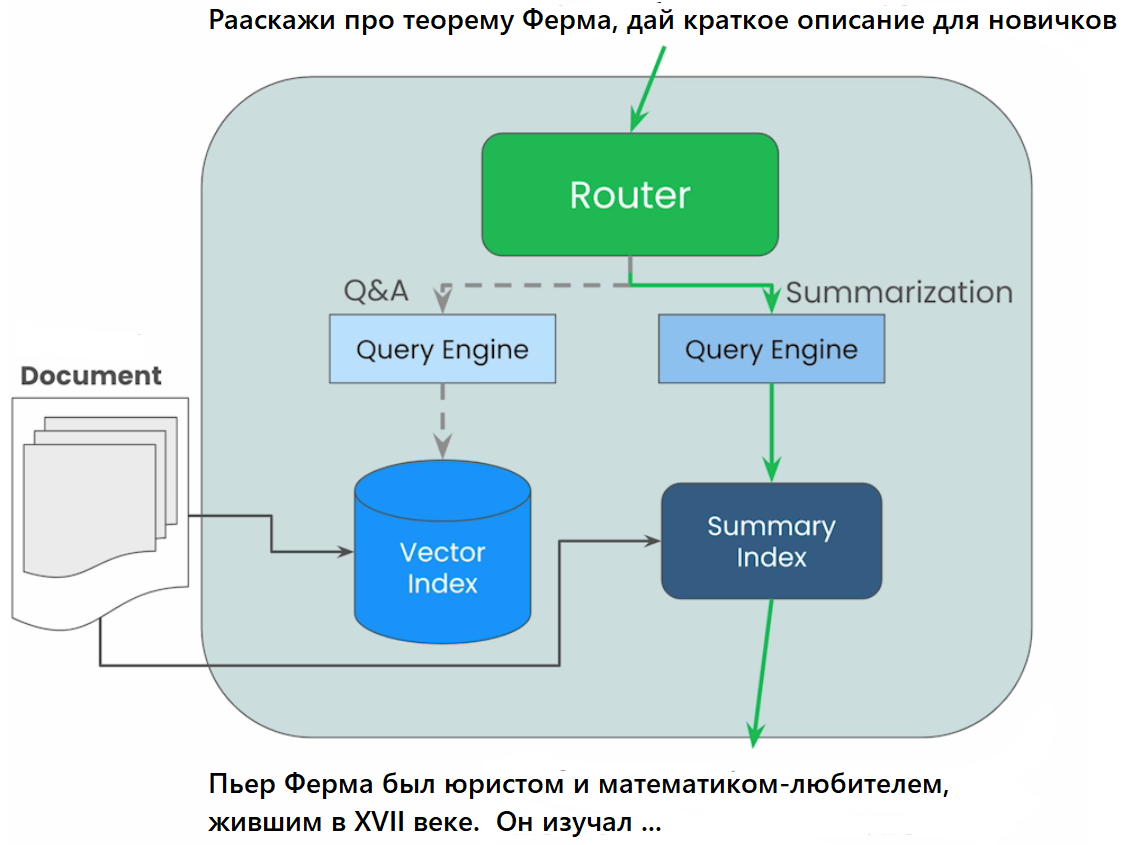

In [ ]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import SummaryIndex, VectorStoreIndex
from llama_index.core.tools import QueryEngineTool
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector
import nest_asyncio
nest_asyncio.apply()

def get_router_query_engine(file_path: str):
    """Получить маршрутизатор запросов."""

    # Использовать заданную модель или модель по умолчанию OpenAI
    llm = OpenAI(model=LL_MODEL)
    embed_model = OpenAIEmbedding(model="text-embedding-ada-002")

    # Загрузить документы
    documents = SimpleDirectoryReader(input_files=[file_path]).load_data()

    # Разделить документы на чанки с размером блока 1024 символа
    splitter = SentenceSplitter(chunk_size=1024)
    nodes = splitter.get_nodes_from_documents(documents)

    # Создать индекс для суммаризации
    summary_index = SummaryIndex(nodes)

    # Создать векторный индекс с использованием embedding модели
    vector_index = VectorStoreIndex(nodes, embed_model=embed_model)

    # Настроить движок запросов для получения суммаризации
    summary_query_engine = summary_index.as_query_engine(
        response_mode="tree_summarize", # Использовать режим суммаризации дерева
        use_async=True, # Асинхронный режим
        llm=llm
    )

    # Настроить движок запросов для векторного поиска
    vector_query_engine = vector_index.as_query_engine(llm=llm)

    # Создать инструмент для обработки запросов для суммаризации
    summary_tool = QueryEngineTool.from_defaults(
        query_engine=summary_query_engine,
        description=(
            "Полезно для вопросов по суммаризации, всей книги или ее частей."
        ),
    )

    # Создать инструмент для обработки запросов для векторного поиска
    vector_tool = QueryEngineTool.from_defaults(
        query_engine=vector_query_engine,
        description=(
            "Полезно для поиска конкретного контекста из книги."
        ),
    )

    # Создать и вернуть маршрутизатор запросов с настроенными инструментами
    query_engine = RouterQueryEngine(
        selector=LLMSingleSelector.from_defaults(),
        query_engine_tools=[
            summary_tool, # Инструмент для суммаризации
            vector_tool,  # Инструмент для векторного поиска
        ],
        verbose=True # Включить подробные логи
    )
    return query_engine

In [ ]:
query_engine = get_router_query_engine("Math_30_seconds.pdf")

In [ ]:
response = query_engine.query("Есть ли в книге ифнормация о Ферма?")
print(str(response))

Selecting query engine 1: Этот выбор наиболее подходит, так как вопрос касается конкретного контекста из книги - наличия информации о Ферма..
Да, в книге есть информация о Пьере Ферма.


In [ ]:
response = query_engine.query("Рааскажи про теорему Ферма, дай краткое описание для новичков. Каждое предложение начинай с новой строки")
print(str(response))

Selecting query engine 0: Полезно для вопросов по суммаризации, связанных с книгой..
Пьер Ферма был юристом и математиком-любителем, жившим в XVII веке.  
Он изучал копию "Арифметики" Диофанта, когда сделал важное открытие.  
Ферма утверждал, что уравнение x^n + y^n = z^n не имеет решений в целых числах для n > 2.  
Он написал, что у него есть поразительное доказательство, но оно не умещается на полях книги.  
Математики пытались доказать эту теорему на протяжении трех столетий.  
В 1994 году британский математик Эндрю Уайлс нашел доказательство теоремы Ферма.  
Теорема Ферма не имеет очевидной практической ценности, но она вдохновила развитие алгебраической теории чисел.


#Внимание:

1. Если вы испытываете проблемы с просмотром ранее опубликованного видео в связи с замедлением Youtube, пишите в кометы под нужным постом в Телеграм - и я залью туда это видео.
2. Приглашаю в Телеграм общаться по этой теме: https://t.me/AiExp01
3. Чат находится здесь: https://t.me/AiExp02
4. Что еще изучить и посмотреть:
*   LlamaIndex https://www.youtube.com/watch?v=myGdYwP83D8&list=PLAzpexGM7JahXip0jNyDEJwPj-wySj3Ix
*   Концепты использования OpenAI API (API ChatGPT)
Playlist: https://www.youtube.com/watch?v=FoLquyNFE_c&list=PLAzpexGM7JagNMDIWUsoO8fbTwbY82ZEN
*   Концепты использования RAG (Retrieval-Augmented Generation)
Playlist: https://www.youtube.com/watch?v=NkjkqsLCweQ&list=PLAzpexGM7Jai1qgfxMkY-6ivOft-7dh8Q
